## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.95, 0.6, 0.2]
redice_lr_patient = [3, 5, 7]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.95, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 2s 34us/step - loss: 1.4066 - accuracy: 0.5100 - val_loss: 1.5336 - val_accuracy: 0.4599
Epoch 9/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3758 - accuracy: 0.5205 - val_loss: 1.5195 - val_accuracy: 0.4674
Epoch 10/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3510 - accuracy: 0.5299 - val_loss: 1.5000 - val_accuracy: 0.4681
Epoch 11/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3255 - accuracy: 0.5375 - val_loss: 1.5017 - val_accuracy: 0.4671
Epoch 12/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3008 - accuracy: 0.5464 - val_loss: 1.4827 - val_accuracy: 0.4691
Epoch 13/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2787 - accuracy: 0.5551 - val_loss: 1.4756 - val_accuracy: 0.4718
Epoch 14/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2582 - accuracy: 0.5634 - val_loss: 1.4772 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 44us/step - loss: 2.2347 - accuracy: 0.2668 - val_loss: 2.1683 - val_accuracy: 0.1647
Epoch 2/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7765 - accuracy: 0.3831 - val_loss: 2.0265 - val_accuracy: 0.2571
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.6452 - accuracy: 0.4234 - val_loss: 1.8696 - val_accuracy: 0.3458
Epoch 4/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.5710 - accuracy: 0.4500 - val_loss: 1.7600 - val_accuracy: 0.3775
Epoch 5/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.5173 - accuracy: 0.4681 - val_loss: 1.6661 - val_accuracy: 0.4131
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4718 - accuracy: 0.4841 - val_loss: 1.6171 - val_accuracy: 0.4239
Epoch 7/25
50000/50000 [==============================] - 2s 36us/st

Epoch 21/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1284 - accuracy: 0.6113 - val_loss: 1.4547 - val_accuracy: 0.4907
Epoch 22/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1128 - accuracy: 0.6169 - val_loss: 1.4547 - val_accuracy: 0.4948
Epoch 23/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.0959 - accuracy: 0.6247 - val_loss: 1.4470 - val_accuracy: 0.4929
Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.0795 - accuracy: 0.6304 - val_loss: 1.4620 - val_accuracy: 0.4884
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.0653 - accuracy: 0.6376 - val_loss: 1.4548 - val_accuracy: 0.4947
Numbers of exp: 5, reduce_factor: 0.60, reduce_patient: 7
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)            

Epoch 6/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4798 - accuracy: 0.4797 - val_loss: 1.5848 - val_accuracy: 0.4510
Epoch 7/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4428 - accuracy: 0.4945 - val_loss: 1.5589 - val_accuracy: 0.4585
Epoch 8/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4103 - accuracy: 0.5080 - val_loss: 1.5331 - val_accuracy: 0.4637
Epoch 9/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3821 - accuracy: 0.5179 - val_loss: 1.5190 - val_accuracy: 0.4697
Epoch 10/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3562 - accuracy: 0.5273 - val_loss: 1.4990 - val_accuracy: 0.4756
Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3317 - accuracy: 0.5356 - val_loss: 1.4895 - val_accuracy: 0.4778
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3082 - accuracy: 0.5467 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 46us/step - loss: 2.2780 - accuracy: 0.2588 - val_loss: 2.1494 - val_accuracy: 0.1744
Epoch 2/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.7834 - accuracy: 0.3772 - val_loss: 2.0013 - val_accuracy: 0.2686
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.6543 - accuracy: 0.4198 - val_loss: 1.8681 - val_accuracy: 0.3469
Epoch 4/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.5798 - accuracy: 0.4468 - val_loss: 1.7489 - val_accuracy: 0.3953
Epoch 5/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.5285 - accuracy: 0.4642 - val_loss: 1.6565 - val_accuracy: 0.4242
Epoch 6/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4845 - accuracy: 0.4794 - val_loss: 1.6025 - val_accuracy: 0.4398
Epoch 7/25
50000/50000 [==============================] - 2s 35us/st

50000/50000 [==============================] - 2s 36us/step - loss: 0.5755 - accuracy: 0.8053 - val_loss: 1.9470 - val_accuracy: 0.4656
Epoch 20/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5372 - accuracy: 0.8207 - val_loss: 1.8745 - val_accuracy: 0.4595
Epoch 21/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5089 - accuracy: 0.8314 - val_loss: 1.8582 - val_accuracy: 0.4709

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0007737808919046074.
Epoch 22/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.4629 - accuracy: 0.8500 - val_loss: 1.8063 - val_accuracy: 0.4820
Epoch 23/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.4333 - accuracy: 0.8592 - val_loss: 2.0740 - val_accuracy: 0.4443
Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.3996 - accuracy: 0.8720 - val_loss: 2.0401 - val_accuracy: 0.4585

Epoch 00024: ReduceLROnPlateau reducing le

Epoch 2/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.5349 - accuracy: 0.4554 - val_loss: 2.0395 - val_accuracy: 0.3063
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4427 - accuracy: 0.4864 - val_loss: 1.7189 - val_accuracy: 0.3950
Epoch 4/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3688 - accuracy: 0.5144 - val_loss: 1.5877 - val_accuracy: 0.4284
Epoch 5/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3107 - accuracy: 0.5345 - val_loss: 1.5356 - val_accuracy: 0.4537
Epoch 6/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.2566 - accuracy: 0.5539 - val_loss: 1.4980 - val_accuracy: 0.4702
Epoch 7/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.2118 - accuracy: 0.5700 - val_loss: 1.6983 - val_accuracy: 0.3840
Epoch 8/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.1634 - accuracy: 0.5888 - val_loss: 1

Epoch 20/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7636 - accuracy: 0.7376 - val_loss: 1.4156 - val_accuracy: 0.5237
Epoch 21/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7459 - accuracy: 0.7437 - val_loss: 1.4225 - val_accuracy: 0.5249

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00012932716053910552.
Epoch 22/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7143 - accuracy: 0.7589 - val_loss: 1.4341 - val_accuracy: 0.5247
Epoch 23/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.7014 - accuracy: 0.7631 - val_loss: 1.4472 - val_accuracy: 0.5314
Epoch 24/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.6898 - accuracy: 0.7686 - val_loss: 1.4320 - val_accuracy: 0.5345

Epoch 00024: ReduceLROnPlateau reducing learning rate to 7.759629806969315e-05.
Epoch 25/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.6723 - accuracy

50000/50000 [==============================] - 2s 39us/step - loss: 1.4797 - accuracy: 0.4793 - val_loss: 1.7457 - val_accuracy: 0.4045
Epoch 4/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4145 - accuracy: 0.5056 - val_loss: 1.6033 - val_accuracy: 0.4491
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.3663 - accuracy: 0.5210 - val_loss: 1.5596 - val_accuracy: 0.4565
Epoch 6/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.3268 - accuracy: 0.5358 - val_loss: 1.5032 - val_accuracy: 0.4712
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2915 - accuracy: 0.5495 - val_loss: 1.4801 - val_accuracy: 0.4756
Epoch 8/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2609 - accuracy: 0.5604 - val_loss: 1.4657 - val_accuracy: 0.4811
Epoch 9/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2330 - accuracy: 0.5712 - val_loss: 1.4650 - val

50000/50000 [==============================] - 2s 39us/step - loss: 1.1135 - accuracy: 0.6222 - val_loss: 1.4391 - val_accuracy: 0.4976
Epoch 23/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1076 - accuracy: 0.6234 - val_loss: 1.4384 - val_accuracy: 0.4956
Epoch 24/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1052 - accuracy: 0.6245 - val_loss: 1.4366 - val_accuracy: 0.4967
Epoch 25/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1022 - accuracy: 0.6260 - val_loss: 1.4358 - val_accuracy: 0.4972
Numbers of exp: 16, reduce_factor: 0.20, reduce_patient: 5
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_____________

Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7074 - accuracy: 0.4055 - val_loss: 1.7455 - val_accuracy: 0.3773
Epoch 8/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6836 - accuracy: 0.4140 - val_loss: 1.7263 - val_accuracy: 0.3841
Epoch 9/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6631 - accuracy: 0.4207 - val_loss: 1.7120 - val_accuracy: 0.3962
Epoch 10/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6468 - accuracy: 0.4261 - val_loss: 1.7045 - val_accuracy: 0.3996
Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6295 - accuracy: 0.4311 - val_loss: 1.6998 - val_accuracy: 0.4055
Epoch 12/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6152 - accuracy: 0.4375 - val_loss: 1.6961 - val_accuracy: 0.4011
Epoch 13/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6014 - accuracy: 0.4408 - val_los

Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.5399 - accuracy: 0.8194 - val_loss: 2.0325 - val_accuracy: 0.4458

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0007737808919046074.
Numbers of exp: 19, reduce_factor: 0.95, reduce_patient: 5
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_58 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_59 (Batc (None

Epoch 8/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1076 - accuracy: 0.6132 - val_loss: 2.1323 - val_accuracy: 0.3394
Epoch 9/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.0604 - accuracy: 0.6300 - val_loss: 1.7713 - val_accuracy: 0.4098
Epoch 10/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.0235 - accuracy: 0.6422 - val_loss: 1.6516 - val_accuracy: 0.4367
Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.9863 - accuracy: 0.6553 - val_loss: 1.8780 - val_accuracy: 0.4082
Epoch 12/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.9551 - accuracy: 0.6672 - val_loss: 1.7397 - val_accuracy: 0.4126
Epoch 13/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.9198 - accuracy: 0.6790 - val_loss: 1.7631 - val_accuracy: 0.4149
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.8888 - accuracy: 0.6912 - val_lo

50000/50000 [==============================] - 2s 36us/step - loss: 0.5219 - accuracy: 0.8430 - val_loss: 1.5030 - val_accuracy: 0.5194

Epoch 00025: ReduceLROnPlateau reducing learning rate to 7.759629806969315e-05.
Numbers of exp: 22, reduce_factor: 0.60, reduce_patient: 5
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_67 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)      

Epoch 9/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4110 - accuracy: 0.5065 - val_loss: 1.5823 - val_accuracy: 0.4418
Epoch 10/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3807 - accuracy: 0.5164 - val_loss: 1.5591 - val_accuracy: 0.4519
Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3528 - accuracy: 0.5277 - val_loss: 1.5472 - val_accuracy: 0.4578
Epoch 12/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3279 - accuracy: 0.5363 - val_loss: 1.5393 - val_accuracy: 0.4597
Epoch 13/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3040 - accuracy: 0.5452 - val_loss: 1.5368 - val_accuracy: 0.4642
Epoch 14/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2819 - accuracy: 0.5539 - val_loss: 1.5274 - val_accuracy: 0.4625
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2611 - accuracy: 0.5594 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 60us/step - loss: 2.5564 - accuracy: 0.1819 - val_loss: 2.2662 - val_accuracy: 0.1723
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.2656 - accuracy: 0.2489 - val_loss: 2.2028 - val_accuracy: 0.2036
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.1270 - accuracy: 0.2844 - val_loss: 2.1185 - val_accuracy: 0.2398
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 2.0343 - accuracy: 0.3105 - val_loss: 2.0292 - val_accuracy: 0.2688
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.9649 - accuracy: 0.3256 - val_loss: 1.9517 - val_accuracy: 0.2986
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.9079 - accuracy: 0.3437 - val_loss: 1.8888 - val_accuracy: 0.3296
Epoch 7/25
50000/50000 [==============================] - 2s 36us/st

Epoch 21/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5536 - accuracy: 0.4585 - val_loss: 1.6713 - val_accuracy: 0.4194
Epoch 22/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5409 - accuracy: 0.4618 - val_loss: 1.6620 - val_accuracy: 0.4251
Epoch 23/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5299 - accuracy: 0.4658 - val_loss: 1.6581 - val_accuracy: 0.4278
Epoch 24/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5198 - accuracy: 0.4701 - val_loss: 1.6493 - val_accuracy: 0.4279
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5082 - accuracy: 0.4746 - val_loss: 1.6421 - val_accuracy: 0.4296


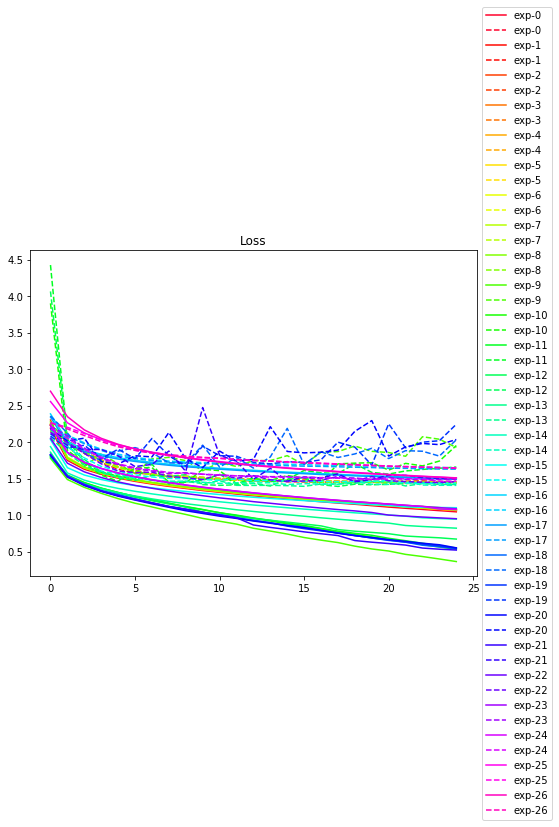

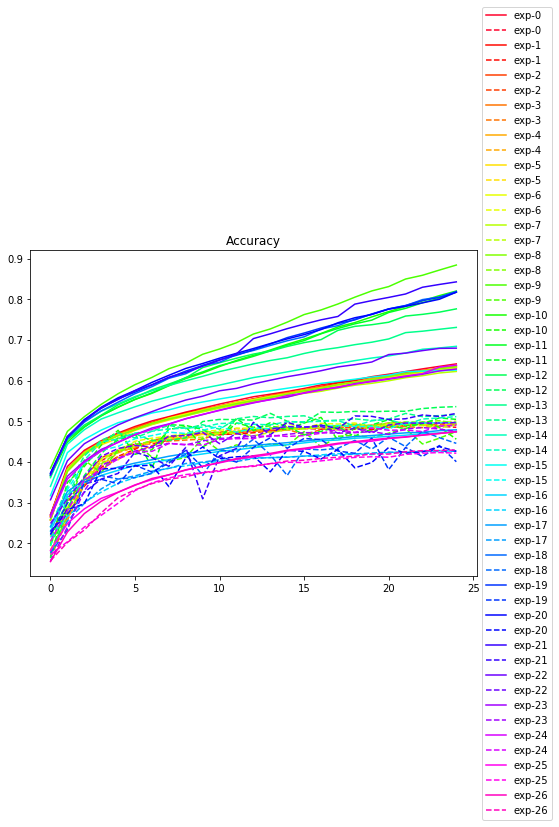

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()